Importo las librerías

In [207]:
import bamboolib as bam
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
import statistics
from sklearn.metrics import roc_curve

Cargo el dataset

In [208]:
df = pd.read_csv("jm_train.csv")

Visualizo el dataset de diferentes formas

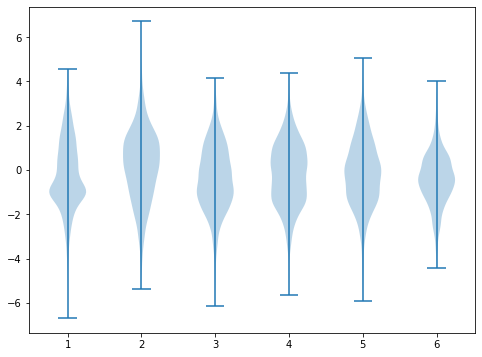

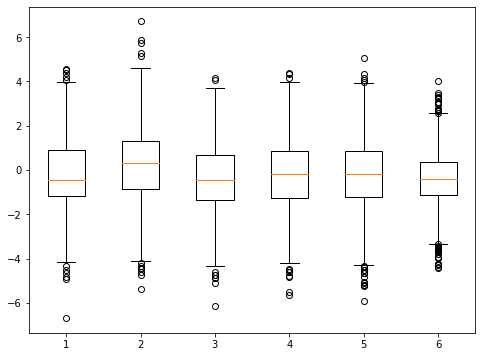

In [209]:
#df
# for column in df.columns:
#     for col in df.columns:
#         sns.scatterplot(data=df, x=column, y=col, hue = "target")
#         plt.show()
# sns.pairplot(df)
plt.figure(figsize=(8,6))
plt.violinplot(df.drop("target",axis=1))
plt.show()
plt.figure(figsize=(8,6))
plt.boxplot(df.drop("target",axis=1))
plt.show()

Los gráficos muestran que se encuentran todos en una escala similar, por lo que tomo la decisión de no escalar. Además, los violinplots muestran que la distribución es bastante normal y los boxplots que no hay tantos outliers, por lo tanto se toma la decisión de no normalizar.

Hago un primer modelo de Random Forest para ver qué tal serían los resultados con estos datos

In [210]:
X = df.drop("target",axis=1)
y = df["target"]

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#Se usa una validación de Hold Out ya que es la más rápida
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)
yhat = rf.predict(X_test)
#Utilizo un f1_score y una matrz de confusión para ver los resultados iniciales
print(f1_score(y_test,yhat,average="macro"))
confusion_matrix(y_test,yhat)

0.760204517588534


array([[109,   9,   7,   3,   2],
       [  7,  85,   9,  14,   1],
       [  9,  14,  82,  10,  16],
       [  4,   8,   4, 105,  16],
       [  3,   0,   7,   7,  99]], dtype=int64)

Los resultados del modelo inicial son bastante positivos así que trabajaré a partir de estos parámetros

In [212]:
#rf.get_params()
print([t.get_depth() for t in rf.estimators_])
print([t.get_n_leaves() for t in rf.estimators_])

[18, 19, 16, 19, 17, 15, 16, 16, 17, 17, 18, 17, 15, 15, 18, 15, 15, 16, 19, 23, 20, 14, 17, 18, 16, 20, 14, 17, 19, 18, 18, 16, 16, 18, 14, 14, 16, 16, 18, 17, 16, 17, 15, 19, 16, 17, 15, 18, 18, 18, 15, 16, 15, 17, 18, 16, 17, 16, 15, 16, 15, 16, 16, 18, 18, 14, 16, 14, 19, 17, 15, 14, 17, 17, 17, 15, 14, 15, 15, 17, 17, 16, 19, 14, 15, 19, 16, 16, 16, 15, 18, 15, 15, 18, 17, 15, 18, 16, 15, 14]
[292, 284, 270, 308, 307, 276, 299, 275, 270, 264, 274, 260, 284, 277, 287, 245, 265, 272, 275, 295, 275, 282, 277, 287, 276, 261, 288, 289, 283, 266, 302, 286, 291, 265, 285, 299, 286, 267, 264, 295, 293, 269, 280, 294, 287, 305, 286, 293, 298, 289, 265, 274, 288, 283, 282, 263, 269, 284, 284, 291, 277, 267, 275, 274, 267, 283, 274, 285, 301, 279, 269, 292, 274, 295, 299, 271, 274, 281, 276, 290, 277, 274, 276, 273, 276, 287, 258, 286, 295, 282, 259, 298, 257, 279, 268, 269, 284, 270, 310, 272]


Que haya más de 300 hojas en algunos de los árboles del Random Forest no es positivo y más de 20 de profundidad también es demasiado, ya que se puede estar sobreajustando a los datos de train.

In [213]:
scores = cross_val_score(rf, X, y, cv=10, scoring = make_scorer(f1_score, average = "macro"))
print(scores)
print(scores.std())

[0.77223381 0.76156041 0.80559242 0.74272033 0.78125644 0.78086058
 0.78470396 0.78047569 0.74800664 0.75173089]
0.018619708693321725


En esta celda vamos a armar un nuevo dataframe basado en kfold que compruebe si los porcentajes de los registros en los que se equivoca son altos o no.

In [214]:
X = np.array(X)
kf = KFold(n_splits=5)
yhatlist = []
yprobalist = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf = RandomForestClassifier()
    rf = rf.fit(X_train, y_train)
    kfoldlist.append(rf)
    yhat = rf.predict(X_test)
    yproba = rf.predict_proba(X_test)
    yhatlist.extend(yhat)
    for i in yproba:
        maxi = max(i)
        yprobalist.append(maxi)
dfcomprobar["yreal"] = y
dfcomprobar["yhat"] = yhatlist
dfcomprobar["yproba"] = yprobalist

In [215]:
print(dfcomprobar.loc[dfcomprobar['yreal'] != dfcomprobar['yhat']].shape[0])
print(dfcomprobar.loc[dfcomprobar['yreal'] != dfcomprobar['yhat']].loc[(dfcomprobar['yproba'] > 0.5)].shape[0])
print(dfcomprobar.loc[dfcomprobar['yreal'] != dfcomprobar['yhat']].loc[(dfcomprobar['yproba'] > 0.6)].shape[0])
print(dfcomprobar.loc[dfcomprobar['yreal'] != dfcomprobar['yhat']].loc[(dfcomprobar['yproba'] > 0.7)].shape[0])
print(dfcomprobar.loc[dfcomprobar['yreal'] != dfcomprobar['yhat']].loc[(dfcomprobar['yproba'] > 0.8)].shape[0])

470
325
203
105
42


In [217]:
dfcomprobar.loc[dfcomprobar['yreal'] == dfcomprobar['yhat']].loc[(dfcomprobar['yproba'] < 0.5)].shape[0]

135

La celda de arriba nos demuestra que de los que se equivoca (469), para 334 se equivoca teniendo más de un 50 % de seguridad; para 201, más de un 60; para 94, más de un 70 y para 48 más de un 80 %. Un 80 % es estar demasiado seguro para estar equivocado, así que reduciendo la complejidad de los árboles intentaremos reducir esto. En cambio, hay 1305 de los que acierta para los que tiene menos de un 50 % de seguridad, lo cual es un dato muy negativo (porque son muchos).

La desviación estándar no es muy alta. Esto sí es bueno. Aun así, intentaremos elegir un modelo 

In [230]:
params={'n_estimators': [400,500,600], #probamos con más árboles, ya que prefiero más árboles sencillos que menos overfit
        'criterion':['gini','entropy'],
        'max_depth': [6,7,8], #probamos mucha menos profundidad
        'max_features': [3,4,5], #probamos usando solo parte de las variables
        'max_leaf_nodes': [50,60,70,80], #probamos varios grupos de hojas (son muchos pero menos que en el modelo)
        }

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf = RandomForestClassifier()
random_solver = RandomizedSearchCV(clf,
                                   params,
                                   scoring=sorted(sklearn.metrics.SCORERS.keys()),
                                   cv = 5,
                                   refit = "f1",
                                   n_jobs=-1)

model_result = random_solver.fit(X_train,y_train)

In [233]:
clf = model_result.best_estimator_
clf = clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print(f1_score(y_test,yhat,average="macro"))
confusion_matrix(y_test,yhat)

0.7187666706326147


array([[110,  13,   6,   3,   0],
       [ 13,  91,  10,  19,   4],
       [  7,  15,  74,  10,  19],
       [  4,   5,   8,  80,  16],
       [  9,   1,   5,   8, 100]], dtype=int64)

In [121]:
model_result.best_params_

{'n_estimators': 600,
 'max_leaf_nodes': 70,
 'max_features': 4,
 'max_depth': 8,
 'criterion': 'entropy'}

Aunque el f1_score es muy inferior al otro Modelo por defecto de SKlearn haremos la comprobación de antes

In [228]:
clf = RandomForestClassifier(n_estimators= 600, max_leaf_nodes= 70, max_features= 4, max_depth= 8,criterion='entropy')
X = np.array(X)
kf = KFold(n_splits=5)
kfoldlist = []
yhatlist = []
f1list = []
yprobalist = []
matrixlist = []
dfcomprobar = pd.DataFrame()
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = clf.fit(X_train, y_train)
    kfoldlist.append(clf)
    yhat = clf.predict(X_test)
    yproba = clf.predict_proba(X_test)
    yhatlist.extend(yhat)
    for i in yproba:
        maxi = max(i)
        yprobalist.append(maxi)
    f1list.append(f1_score(yhat,y_test,average = "macro"))
dfcomprobar["yreal"] = y
dfcomprobar["yhat"] = yhatlist
dfcomprobar["yproba"] = yprobalist

In [232]:
statistics.mean(f1list)

0.7566260656581308

In [234]:
print(dfcomprobar.loc[dfcomprobar['yreal'] != dfcomprobar['yhat']].shape[0])
print(dfcomprobar.loc[dfcomprobar['yreal'] != dfcomprobar['yhat']].loc[(dfcomprobar['yproba'] > 0.5)].shape[0])
print(dfcomprobar.loc[dfcomprobar['yreal'] != dfcomprobar['yhat']].loc[(dfcomprobar['yproba'] > 0.6)].shape[0])
print(dfcomprobar.loc[dfcomprobar['yreal'] != dfcomprobar['yhat']].loc[(dfcomprobar['yproba'] > 0.7)].shape[0])
print(dfcomprobar.loc[dfcomprobar['yreal'] != dfcomprobar['yhat']].loc[(dfcomprobar['yproba'] > 0.8)].shape[0])

507
353
218
106
41


In [235]:
dfcomprobar.loc[dfcomprobar['yreal'] == dfcomprobar['yhat']].loc[(dfcomprobar['yproba'] < 0.5)].shape[0]


140

Como se ve, aunque hay 695 fallos. Muchos más fallos que en el otro modelo. solo está seguro de su error en más de un 50 % para 289; solo para 118 en más de un 60; solo 19 en más de un 70 y a ninguno de los que falla está seguro en más de un 80. Hay 200 que acierta en los que no está seguro en más de un 50 %. Ese dato está muy bien ya que son solo un poco más que el otro modelo.

Estos parámetros están muy bien así que vamos a hacer la predicción:

In [242]:
X_verdadera = pd.read_csv("jm_X_test.csv")

Reentrenamos la x y la y:

In [252]:
X = df.drop("target",axis=1)
y = df["target"]

In [253]:
clf = RandomForestClassifier(n_estimators= 600, max_leaf_nodes= 70, max_features= 4, max_depth= 8,criterion='entropy')
clf.fit(X, y)


Y predecimos:

In [258]:
yhat_verdadera = pd.DataFrame(clf.predict(X_verdadera),columns=["yhat"])

In [259]:
yhat_verdadera.to_csv("yhat.csv")